# Exercise 5: Unsupervised Learning

Extension of https://oist.github.io/BrainComputation/Bayesian.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Bayesian Linear Regression

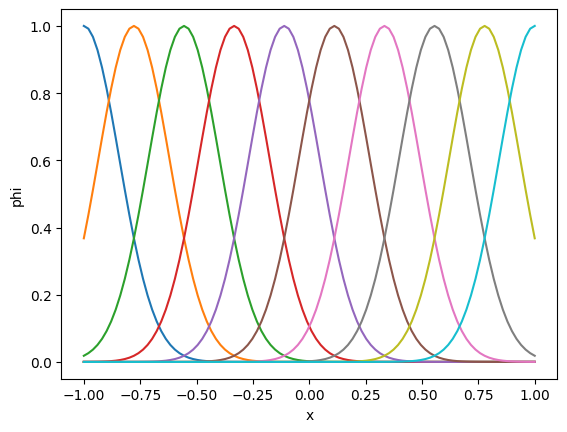

In [2]:
# 1D Gaussian basis functions 
def gbf1(x, xrange=[-1.,1.], M=10):
    """Gaussian basis functions: x can be a 1D array"""
    xc = np.linspace(xrange[0], xrange[1], num=M)  # centers
    xd = (xc[1]-xc[0])  # interval
    # x can be an array for N data points
    return np.exp(-((np.tile(x,[M,1]).T - xc)/xd)**2)
# example
x = np.linspace(-1, 1, 100)
plt.plot(x, gbf1(x, M=10));
plt.xlabel("x"); plt.ylabel("phi");

In [3]:
def blr(X, t, alpha=1., beta=10.):
    """Bayesian linear regression
    alpha: inv. variance of weight prior 
    beta: inv. variance of observation noise
    """
    N, D = X.shape
    S = np.linalg.inv(alpha*np.eye(D) + beta*X.T@X) # posterior covariance
    m = beta*S@X.T@t   # posterior mean
    return m, S

In [4]:
def target(x):
    """Target function"""
    return np.exp(-0.2*x)*(0.5*np.sin(x) + 0.3*np.cos(2*x))

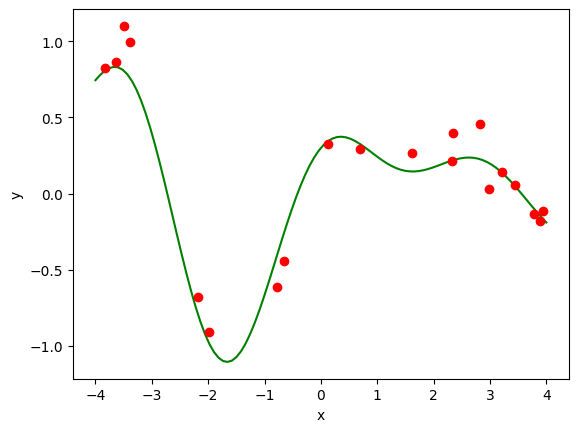

In [23]:
# training data
N = 20
eps = 0.2  # noise size
xr = 4   # range of x
x = np.random.uniform(-xr, xr, size=N)  
f = target(x)  # target function
t = f + np.random.normal(scale=eps, size=N) # with noise
# data for testing/plotting
Np = 100
xp = np.linspace(-xr, xr, Np)
fp = target(xp)
plt.plot(xp, fp, "g")  # target function
plt.plot(x, t, "ro");  # training data
plt.xlabel("x"); plt.ylabel("y");

[ 0.40044624  0.92921743 -0.63541376 -0.85346821 -0.00273305  0.35348191
  0.00617618  0.26267304  0.15210254 -0.21942228]


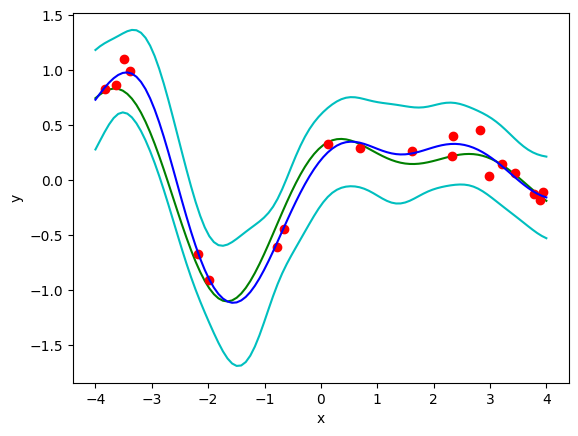

In [24]:
alpha = 0.5 # inverse variance of weight prior
beta = 10 # inverse variance of observation noise
M = 10  # number of basis functions
Phi = gbf1(x, [-xr,xr], M)  # Gaussian basis functions
m, S = blr(Phi, t, alpha=alpha, beta=beta)  # Bayesian linear regression
print(m)
# test data
Phip = gbf1(xp, [-xr,xr], M)
yp = Phip@m.T
plt.plot(xp, fp, "g")  # target function
plt.plot(x, t, "ro");  # training data
plt.plot(xp, yp, "b");  # MAP estimate
# predictive distribution
sigma = np.sqrt(1/beta + np.sum(Phip@S*Phip, axis=1))
plt.plot(xp, yp+sigma, "c")
plt.plot(xp, yp-sigma, "c")
plt.xlabel("x"); plt.ylabel("y");

Less data (N) will decrease fit match with the underlying target function. Number of bases (M) being too high can produce an overfit model. Too high $\alpha$ being will constrain bases to have similar weights, thereby producing "flatter" fits, while $\beta$ being too low will cause lesser information from the observed data to flow into the bases weights. 

### 2. Model Log Evidence and Prediction Error

In [ ]:
def logev(X, t, m, S, alpha, beta):
    """log evidence for Bayesian regression
    m: posterior mean
    S: posterior covariance
    alpha: inv. variance of weight prior 
    beta: inv. variance of observation noise
    """
    N, D = X.shape
    em = t - X@m.T  # error with MAP estimate
    # log evidence
    lev = -beta/2*np.dot(em,em) - alpha/2*np.dot(m,m) + np.log(abs(np.linalg.det(S)))/2 + D/2*np.log(alpha) + N/2*(np.log(beta/(2*np.pi)))
    return lev

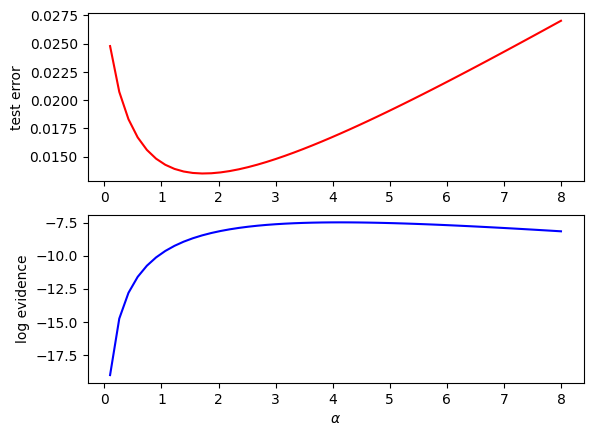

In [33]:
# compare different values of alpha
M = 10  # number of basis functions
alphas = np.linspace(0.1, 8, 50)
beta = 10
mse = []  # mean square errors
lev = []  # log evidences
for alpha in alphas:
    Phi = gbf1(x, [-xr,xr], M)  # Gaussian basis functions
    m, S = blr(Phi, t, alpha, beta)
    lev.append(logev(Phi, t, m, S, alpha, beta))
    # test data
    Phip = gbf1(xp, [-xr,xr], M)  # Gaussian basis functions
    err = fp - Phip@m.T  # validation error
    mse.append( np.dot(err,err)/Np)
    #print(alpha, beta, lev, mse)
plt.subplot(2,1,1)
plt.plot(alphas, mse, "r"); plt.ylabel("test error");
plt.subplot(2,1,2)
plt.plot(alphas, lev, "b"); plt.ylabel("log evidence");
plt.xlabel(r"$\alpha$");

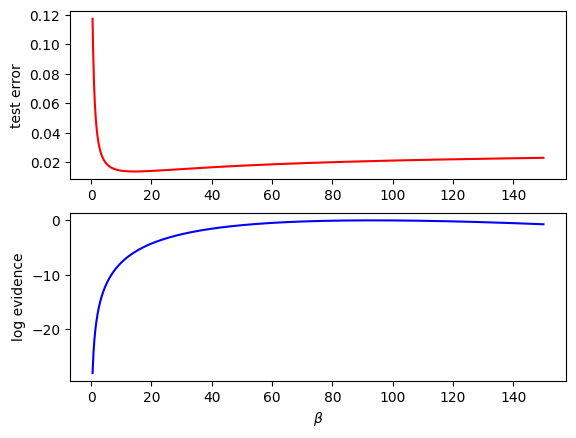

In [41]:
# compare different values of beta
M = 10  # number of basis functions
alpha = 2.5 
betas = np.linspace(0.5, 150, 1000)
mse = []  # mean square errors
lev = []  # log evidences
for beta in betas:
    Phi = gbf1(x, [-xr,xr], M)  # Gaussian basis functions
    m, S = blr(Phi, t, alpha, beta)
    lev.append( logev(Phi, t, m, S, alpha, beta))
    # test data
    Phip = gbf1(xp, [-xr,xr], M)  # Gaussian basis functions
    err = fp - Phip@m.T  # validation error
    mse.append( np.dot(err,err)/Np)
    #print(alpha, beta, lev, mse)
plt.subplot(2,1,1)
plt.plot(betas, mse, "r"); plt.ylabel("test error");
plt.subplot(2,1,2)
plt.plot(betas, lev, "b"); plt.ylabel("log evidence");
plt.xlabel(r"$\beta$");

As can be seen above, model evidence increases and then tapers off as test error decreases and begins to later increase again, respectively. Both criteria can be used together to make a trade-off for selecting optimal parameter values.

### 3. Backward-Forward Algorithm on Chains

In [55]:
class Markov:
    """Class for a Markov chain"""
    def __init__(self, ptr):
        """Create a new environment"""
        self.ptr = np.asarray(ptr)  # transition matrix p(x'|x)
        self.Ns = self.ptr.shape[0]  # number of states
        
    def sample(self, x0=0, step=1):
        """generate a sample sequence from x0"""
        seq = np.zeros(step+1, dtype=int) # sequence buffer
        seq[0] = x0
        for t in range(step):
            pt1 = self.ptr[:, seq[t]] # prob. of new states (column for current state)
            seq[t+1] = np.random.choice(self.Ns, p=pt1) # sample 
        return seq
    
    def forward(self, p0, step=1):
        """forward message from initial distribution p0"""
        p0 = np.asarray(p0, dtype=float)
        alpha = np.zeros((step+1, self.Ns)) # priors
        alpha[0] = p0 / p0.sum()  # ensure normalized
        for t in range(step):
            alpha[t+1] = self.ptr @ alpha[t] 
        return alpha

    def backward(self, obs, step=1):
        """backward message from terminal observation"""
        obs = np.asarray(obs, dtype=float)
        obs = obs / obs.sum()  # allow soft terminal obs
        beta = np.zeros((step+1, self.Ns)) # likelihoods
        beta[-1] = obs  # observation at T
        for t in range(step, 0, -1): # toward 0
            beta[t-1] = beta[t] @ self.ptr
        return beta
    
    def posterior(self, p0, obs, step):
        """forward-backward algorithm"""
        alpha = self.forward(p0, step)
        beta = self.backward(obs, step)
        post = alpha * beta  # elementwise
        Z = post.sum(axis=1, keepdims=True)
        post = post / Z
        return post, alpha, beta, Z.ravel()

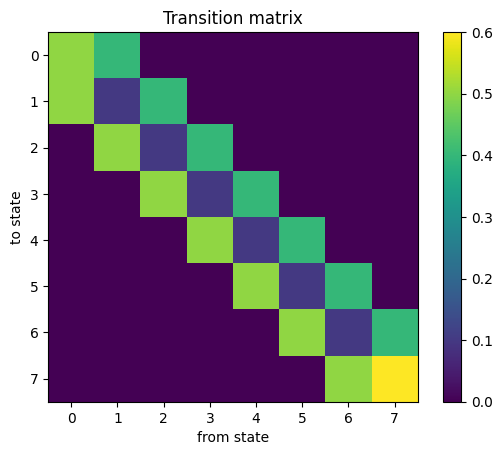

In [56]:
# random walk over fixed states with "walls" at boundaries
def line_chain(N=8, p_right=0.6, p_left=0.3, p_stay=None):
    if p_stay is None:
        p_stay = 1.0 - (p_right + p_left)
    assert p_right >= 0 and p_left >= 0 and p_stay >= 0
    assert np.isclose(p_right + p_left + p_stay, 1.0)
    P = np.zeros((N, N))
    for j in range(N):  # column j = from-state j
        # attempt to go left
        if j > 0:
            P[j-1, j] += p_left
        else:
            P[j, j] += p_left  # reflect into "stay" at boundary
        # attempt to go right
        if j < N-1:
            P[j+1, j] += p_right
        else:
            P[j, j] += p_right  # reflect into "stay" at boundary
        # stay
        P[j, j] += p_stay
    # sanity: column-stochastic
    assert np.allclose(P.sum(axis=0), 1.0)
    return P

N = 8
p_right, p_left, p_stay = 0.5, 0.4, 0.1
P = line_chain(N, p_right, p_left, p_stay)
plt.figure()
plt.title("Transition matrix")
plt.xlabel("from state")
plt.ylabel("to state")
plt.imshow(P)
plt.colorbar()
chain = Markov(P)

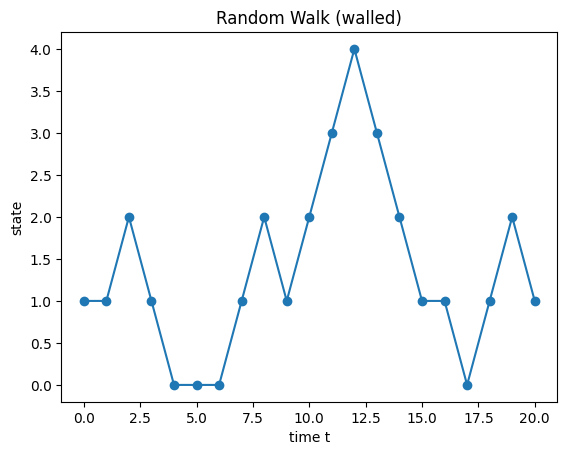

In [65]:
T = 20
seq = chain.sample(x0=1, step=T)
plt.figure()
plt.title("Random Walk (walled)")
plt.xlabel("time t")
plt.ylabel("state")
plt.plot(range(T+1), seq, marker='o')

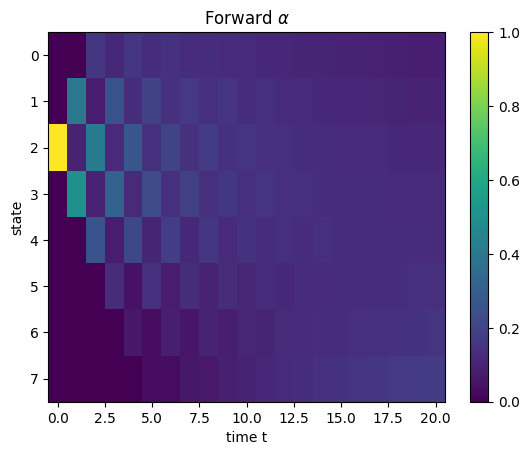

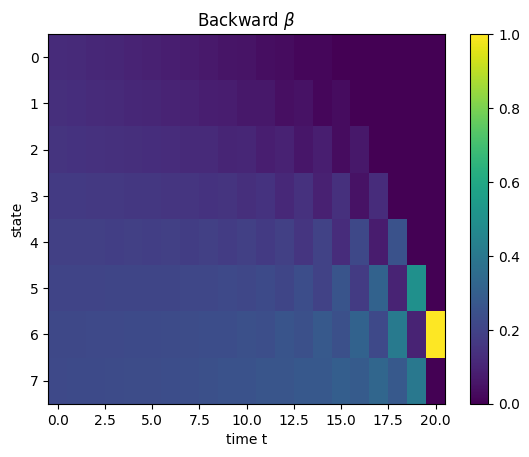

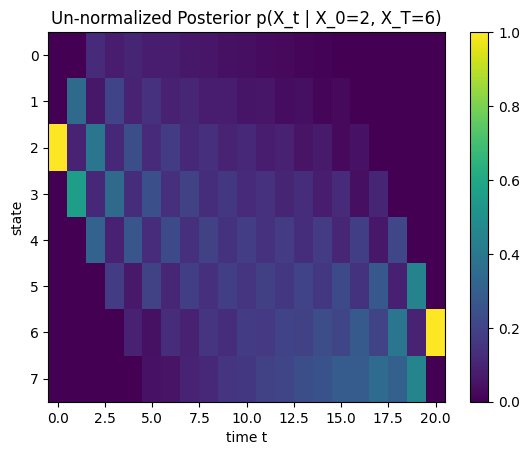

In [78]:
p0 = np.eye(N)[2] # start localized near left (state 2)
obs_T = np.eye(N)[6] # constrain to end near right (state 6)
post, alpha, beta, Z = chain.posterior(p0, obs_T, T)

plt.figure()
plt.title("Forward $\\alpha$")
plt.xlabel("time t")
plt.ylabel("state")
plt.imshow(alpha.T, aspect='auto')
plt.colorbar()

plt.figure()
plt.title("Backward $\\beta$")
plt.xlabel("time t")
plt.ylabel("state")
plt.imshow(beta.T, aspect='auto')
plt.colorbar()

plt.figure()
plt.title("Un-normalized Posterior p(X_t | X_0=2, X_T=6)")
plt.xlabel("time t")
plt.ylabel("state")
plt.imshow(post.T, aspect='auto')
plt.colorbar()

### 4. Dynamic Bayesian Inference

Observation model with independent sensors allowing for different degree of reliabilities. This will require modelling sensor readings as one vector, instead of being coupled into a single distribution — essentially re-purposing the previous observation matrix to now allow independent (state x sensor)-wise probability distributions.

In [ ]:
class HMM(Markov):
    def __init__(self, ptr, q, prior=None):
        """
        ptr: transition probability matrix
        q: sensor reliability matrix (K, S) where q[k,s] = P(sensor_k=1|state=s)
        """
        super().__init__(ptr)
        self.q = np.asarray(q, float)  # (K sensors, S states)
        self.K, S = self.q.shape  # number of sensors, states
        assert S == self.Ns
        self.reset(prior)

    def reset(self, prior=None):
        """reset state probability"""
        if prior is None:
            self.pst = np.ones(self.Ns) / self.Ns
        else:
            prior = np.asarray(prior, float)
            self.pst = prior / prior.sum()
        self.pred = np.zeros(self.Ns)

    def sample(self, x0=0, step=10, rng=None):
        """generate sample sequence with independent sensor observations"""
        rng = np.random.default_rng() if rng is None else rng
        xt = np.zeros(step, dtype=int)  # state sequence
        Y = np.zeros((step, self.K), dtype=int)  # sensor readings (binary)
        xt[0] = int(x0)
        # generate sensor readings: Y[t,k] ~ Bernoulli(q[k, xt[t]])
        Y[0] = (rng.random(self.K) < self.q[:, xt[0]]).astype(int)
        for t in range(1, step):
            # sample next state
            ps = self.ptr[:, xt[t-1]]
            xt[t] = rng.choice(self.Ns, p=ps)
            # sample sensor readings for current state
            Y[t] = (rng.random(self.K) < self.q[:, xt[t]]).astype(int)
        return xt, Y

    def predict(self):
        """predictive prior by transition model"""
        self.pred = self.ptr @ self.pst
    
    def _likelihood(self, y_vec):
        """compute likelihood P(y_vec|state) for all states: log-sum ~ product"""
        S = self.Ns
        ll = np.zeros(S)  # log-likelihood
        eps = 1e-12
        any_used = False
        
        for k in range(self.K):
            y = y_vec[k]
            # skip missing sensors
            if y is None or (isinstance(y, float) and np.isnan(y)):
                continue
            any_used = True
            
            # clip probabilities for numerical stability
            qk = np.clip(self.q[k], eps, 1 - eps)  # shape (S,)
            # log-likelihood: y*log(q) + (1-y)*log(1-q)
            ll += y * np.log(qk) + (1 - y) * np.log(1 - qk)
        
        if not any_used:
            # no useful sensory input => uniform likelihood (easy assumption)
            # note: this could have multiple kinds of alternatives
            return np.ones(S)
        
        # convert back to probability (numerically stable)
        ll -= ll.max()  # prevent overflow
        return np.exp(ll)
    
    def update(self, y_vec):
        """update posterior by sensor observations"""
        likelihood = self._likelihood(y_vec)
        posterior_unnorm = likelihood * self.pred
        Z = np.sum(posterior_unnorm)
        if Z > 0:
            self.pst = posterior_unnorm / Z
        else:
            # fallback for pathologically contradictory data
            self.pst = np.ones(self.Ns) / self.Ns
    
    def step(self, y_vec):
        """one step of dynamic Bayesian inference"""
        self.predict()
        self.update(y_vec)
        return self.pst

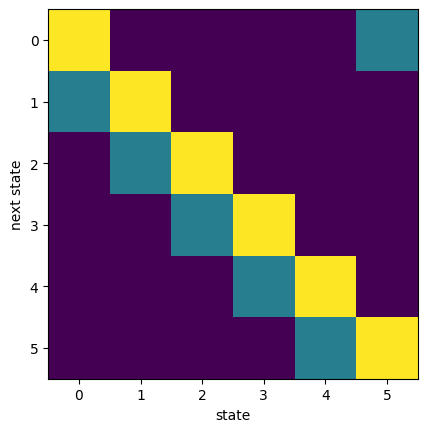

In [80]:
# random walk on a ring
ns = 6   # ring size
ps = 0.3  # shift probability
Ptr = np.zeros((ns, ns))  # transition matrix
for i in range(ns):
    Ptr[i,i] = 1 - ps
    Ptr[(i+1)%ns, i] = ps
plt.imshow(Ptr)
plt.xlabel("state"); plt.ylabel("next state");

Sensor reliability matrix q[sensor, state]:
Rows: sensors, Columns: states


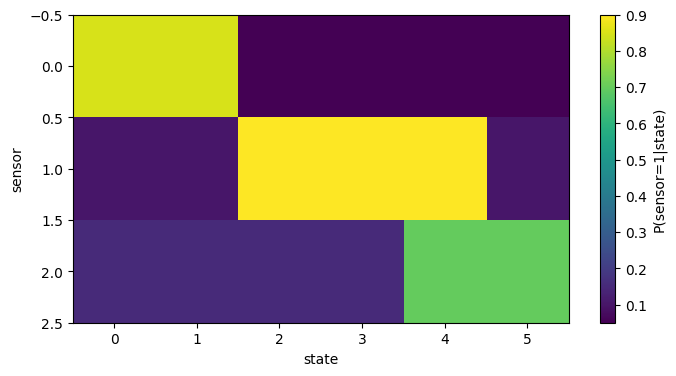

In [ ]:
# independent sensor model with different reliabilities 
# (or basically an informative firing/observation model)
K = 3  # number of sensors
q = np.zeros((K, ns))  # q[k,s] = P(sensor_k=1|state=s)

# sensor 0: detects states 0,1 with high reliability
q[0, :] = 0.05  # low false positive rate
q[0, [0, 1]] = 0.85  # high true positive rate

# sensor 1: detects states 2,3,4 with different reliability
q[1, :] = 0.1  # slightly higher false positive rate
q[1, [2, 3, 4]] = 0.9  # very high true positive rate

# sensor 2: detects states 4,5 with moderate reliability
q[2, :] = 0.15  # higher false positive rate
q[2, [4, 5]] = 0.7  # moderate true positive rate

print("Sensor reliability matrix q[sensor, state]:")
print("Rows: sensors, Columns: states")
plt.figure(figsize=(8, 4))
plt.imshow(q, aspect='auto')
plt.xlabel("state"); plt.ylabel("sensor")
plt.colorbar(label="P(sensor=1|state)");

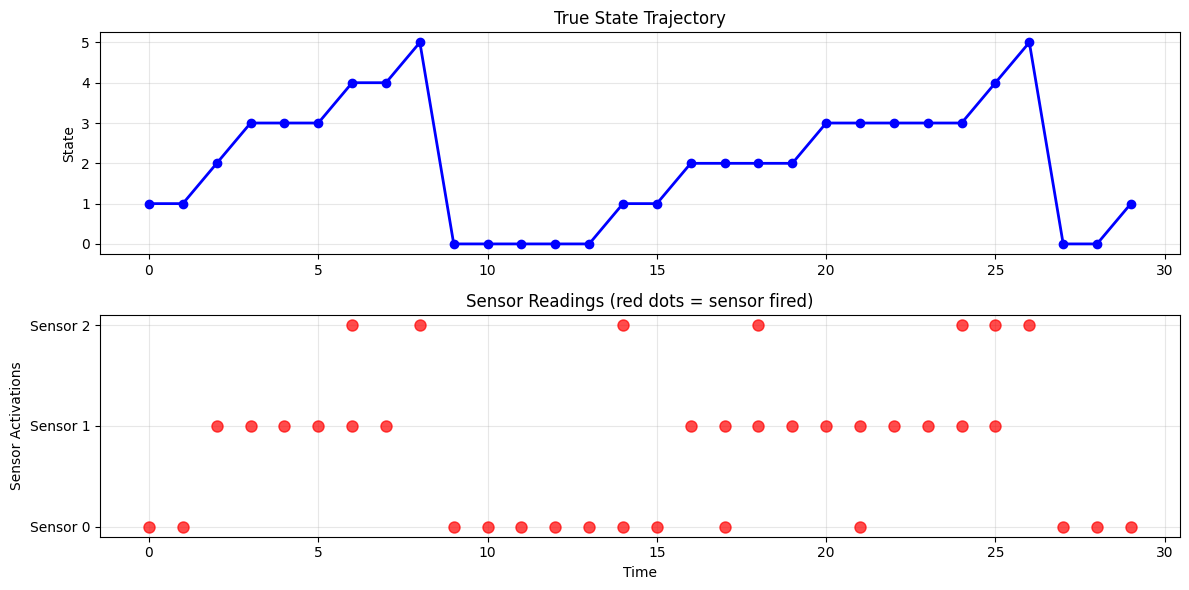

In [ ]:
# HMM with independent sensors
ring = HMM(Ptr, q)

# sample a state trajectory and sensor observations
T = 30
xt, Y = ring.sample(x0=1, step=T, rng=np.random.default_rng(42))

# plot state trajectory and sensor readings
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(xt, 'bo-', linewidth=2, markersize=6)
plt.ylabel('State')
plt.title('True State Trajectory')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
# Plot each sensor as a separate row
for k in range(K):
    plt.plot(np.where(Y[:, k] == 1)[0], k * np.ones(np.sum(Y[:, k])), 
             'ro', markersize=8, alpha=0.7, label=f'Sensor {k}')

plt.yticks(range(K), [f'Sensor {k}' for k in range(K)])
plt.xlabel('Time')
plt.ylabel('Sensor Activations')
plt.title('Sensor Readings (red dots = sensor fired)')
plt.grid(True, alpha=0.3)
plt.tight_layout();

Average entropy during gaps: 1.480
Average entropy outside gaps: 0.751


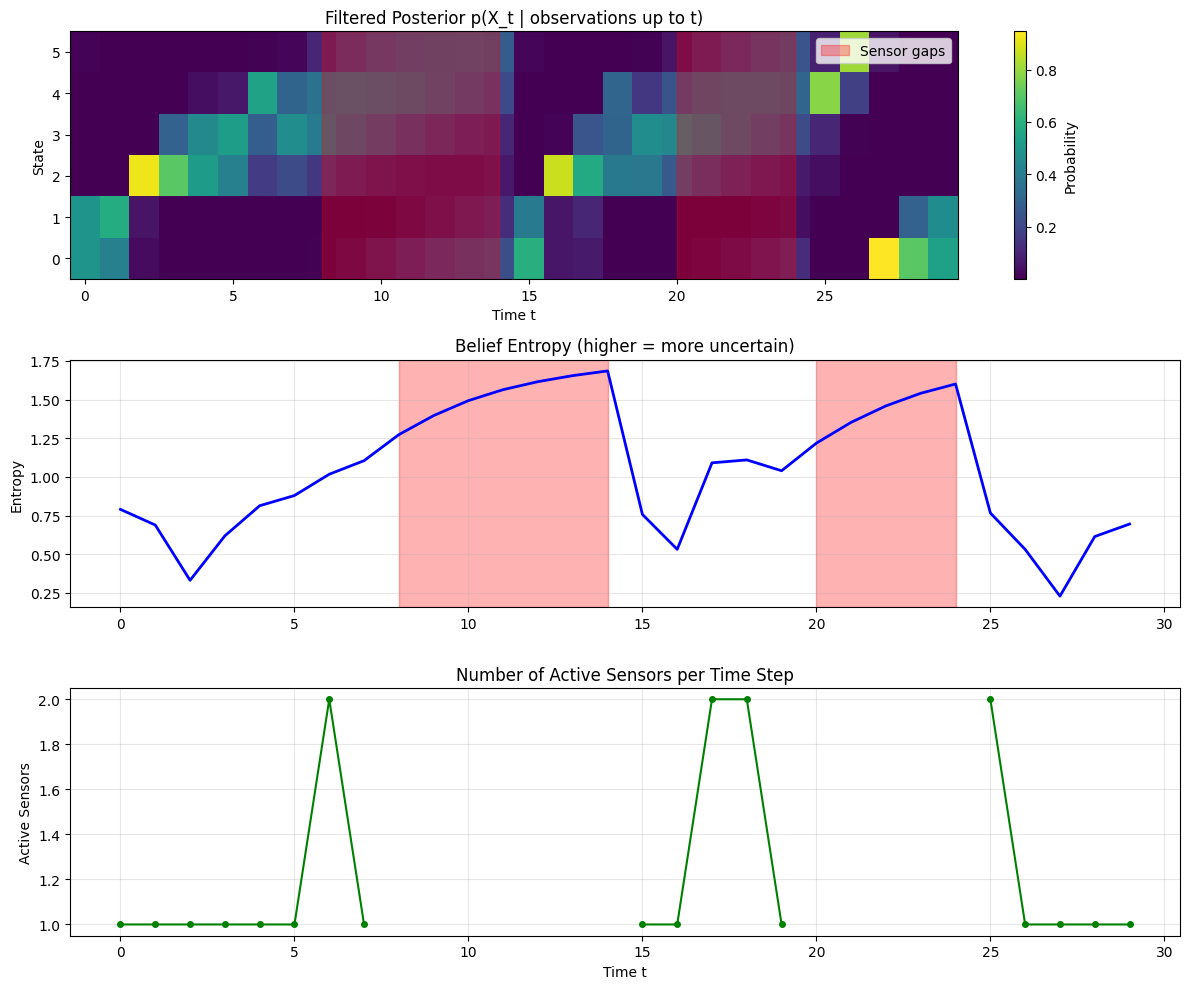

In [ ]:
# dynamic Bayesian inference with independent sensors
# create sensor gaps to demonstrate prediction vs correction
# written with the help of Claude Code
Y_masked = Y.astype(object).copy()  # allow None values
gaps = [(8, 15), (20, 25)]  # time intervals with no sensor data

for start, end in gaps:
    Y_masked[start:end, :] = None  # all sensors unavailable

# perform filtering
post = np.zeros((T, ns))  # posterior trajectory
ring.reset()
for t in range(T):
    post[t] = ring.step(Y_masked[t])

# compute entropy to show belief sharpening/diffusion
def entropy(p):
    p = np.clip(p, 1e-12, 1.0)
    return -(p * np.log(p)).sum()

H = np.array([entropy(post[t]) for t in range(T)])

# plotting
plt.figure(figsize=(12, 10))

# posterior heatmap
plt.subplot(3, 1, 1)
plt.imshow(post.T, origin='lower', aspect='auto')
plt.xlabel('Time t')
plt.ylabel('State')
plt.title('Filtered Posterior p(X_t | observations up to t)')
plt.colorbar(label='Probability')

# mark sensor gaps
for start, end in gaps:
    plt.axvspan(start, end-1, alpha=0.3, color='red', 
                label='Sensor gaps' if start == gaps[0][0] else "")
plt.legend()

# entropy over time
plt.subplot(3, 1, 2)
plt.plot(H, 'b-', linewidth=2)
plt.ylabel('Entropy')
plt.title('Belief Entropy (higher = more uncertain)')
plt.grid(True, alpha=0.3)

# mark sensor gaps
for start, end in gaps:
    plt.axvspan(start, end-1, alpha=0.3, color='red')

# sensor availability
plt.subplot(3, 1, 3)
sensor_count = np.zeros(T)
for t in range(T):
    if Y_masked[t, 0] is not None:  # if sensors available
        sensor_count[t] = np.sum(Y_masked[t])
    else:
        sensor_count[t] = np.nan

plt.plot(sensor_count, 'go-', markersize=4)
plt.ylabel('Active Sensors')
plt.xlabel('Time t')
plt.title('Number of Active Sensors per Time Step')
plt.grid(True, alpha=0.3)

plt.tight_layout()

print(f"Average entropy during gaps: {np.nanmean([H[start:end].mean() for start, end in gaps]):.3f}")
print(f"Average entropy outside gaps: {np.nanmean([H[:gaps[0][0]].mean(), H[gaps[0][1]:gaps[1][0]].mean(), H[gaps[1][1]:].mean()]):.3f}")

\nInference Quality Summary:
Scenario             | Accuracy | Avg Entropy | Information Quality
-----------------------------------------------------------------
High Reliability     |     0.62 |        0.48 | Medium
Medium Reliability   |     0.44 |        0.85 | Low
Poor Reliability     |     0.31 |        1.54 | Low


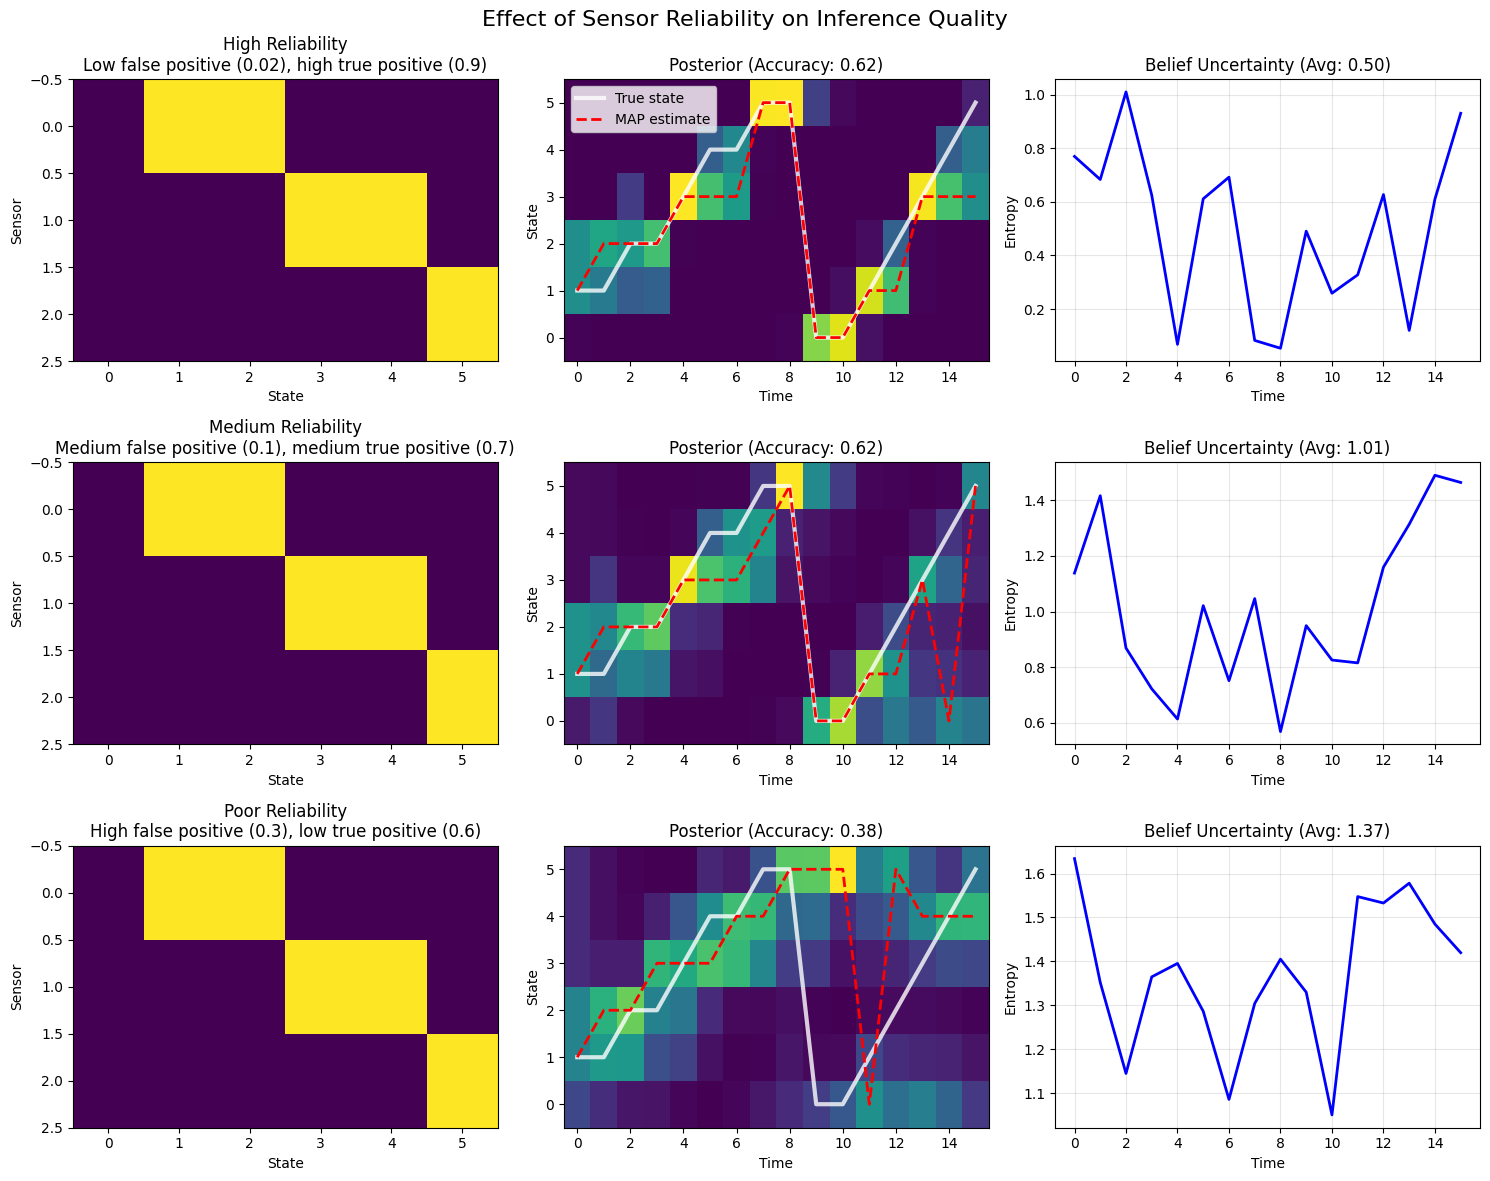

In [85]:
# comparison of sensor reliabilities: demonstrate how different sensor 
# reliabilities affect inference quality
# written with the help of Claude Code
np.random.seed(123)

# create scenarios with different sensor reliability patterns
scenarios = {
    'High Reliability': {
        'q': np.array([[0.02, 0.9, 0.9, 0.02, 0.02, 0.02],
                       [0.02, 0.02, 0.02, 0.9, 0.9, 0.02],
                       [0.02, 0.02, 0.02, 0.02, 0.02, 0.9]]),
        'description': 'Low false positive (0.02), high true positive (0.9)'
    },
    'Medium Reliability': {
        'q': np.array([[0.1, 0.7, 0.7, 0.1, 0.1, 0.1],
                       [0.1, 0.1, 0.1, 0.7, 0.7, 0.1], 
                       [0.1, 0.1, 0.1, 0.1, 0.1, 0.7]]),
        'description': 'Medium false positive (0.1), medium true positive (0.7)'
    },
    'Poor Reliability': {
        'q': np.array([[0.3, 0.6, 0.6, 0.3, 0.3, 0.3],
                       [0.3, 0.3, 0.3, 0.6, 0.6, 0.3],
                       [0.3, 0.3, 0.3, 0.3, 0.3, 0.6]]),
        'description': 'High false positive (0.3), low true positive (0.6)'
    }
}

# fixed true trajectory for comparison
true_state_seq = [1, 1, 2, 2, 3, 4, 4, 5, 5, 0, 0, 1, 2, 3, 4, 5]
T_comp = len(true_state_seq)

fig, axes = plt.subplots(len(scenarios), 3, figsize=(15, 12))
fig.suptitle('Effect of Sensor Reliability on Inference Quality', fontsize=16)

for row, (scenario_name, scenario_data) in enumerate(scenarios.items()):
    q_scenario = scenario_data['q']
    
    # create HMM for this scenario
    hmm_scenario = HMM(Ptr, q_scenario)
    
    # generate synthetic observations based on true states
    Y_scenario = np.zeros((T_comp, 3), dtype=int)
    for t, state in enumerate(true_state_seq):
        for k in range(3):
            Y_scenario[t, k] = np.random.binomial(1, q_scenario[k, state])
    
    # perform inference
    post_scenario = np.zeros((T_comp, ns))
    hmm_scenario.reset()
    for t in range(T_comp):
        post_scenario[t] = hmm_scenario.step(Y_scenario[t])
    
    # compute metrics
    predicted_states = np.argmax(post_scenario, axis=1)
    accuracy = np.mean(predicted_states == true_state_seq)
    avg_entropy = np.mean([entropy(post_scenario[t]) for t in range(T_comp)])
    
    # plot sensor reliability matrix
    axes[row, 0].imshow(q_scenario, aspect='auto')
    axes[row, 0].set_title(f'{scenario_name}\n{scenario_data["description"]}')
    axes[row, 0].set_xlabel('State')
    axes[row, 0].set_ylabel('Sensor')
    
    # plot posterior evolution
    im = axes[row, 1].imshow(post_scenario.T, origin='lower', aspect='auto')
    axes[row, 1].plot(true_state_seq, 'w-', linewidth=3, alpha=0.8, label='True state')
    axes[row, 1].plot(predicted_states, 'r--', linewidth=2, label='MAP estimate')
    axes[row, 1].set_xlabel('Time')
    axes[row, 1].set_ylabel('State')
    axes[row, 1].set_title(f'Posterior (Accuracy: {accuracy:.2f})')
    if row == 0:
        axes[row, 1].legend()
    
    # plot entropy
    H_scenario = [entropy(post_scenario[t]) for t in range(T_comp)]
    axes[row, 2].plot(H_scenario, 'b-', linewidth=2)
    axes[row, 2].set_xlabel('Time')
    axes[row, 2].set_ylabel('Entropy')
    axes[row, 2].set_title(f'Belief Uncertainty (Avg: {avg_entropy:.2f})')
    axes[row, 2].grid(True, alpha=0.3)

plt.tight_layout()

print("\\nInference Quality Summary:")
print("Scenario             | Accuracy | Avg Entropy | Information Quality")
print("-" * 65)
for scenario_name, scenario_data in scenarios.items():
    # quick recalculation for summary
    q_test = scenario_data['q']
    hmm_test = HMM(Ptr, q_test)
    post_test = np.zeros((T_comp, ns))
    hmm_test.reset()
    Y_test = np.zeros((T_comp, 3), dtype=int)
    for t, state in enumerate(true_state_seq):
        for k in range(3):
            Y_test[t, k] = np.random.binomial(1, q_test[k, state])
        post_test[t] = hmm_test.step(Y_test[t])
    
    pred_test = np.argmax(post_test, axis=1)
    acc_test = np.mean(pred_test == true_state_seq)
    ent_test = np.mean([entropy(post_test[t]) for t in range(T_comp)])
    quality = "High" if acc_test > 0.8 else "Medium" if acc_test > 0.6 else "Low"
    
    print(f"{scenario_name:20} | {acc_test:8.2f} | {ent_test:11.2f} | {quality}");